In [1]:
import os
from data import import_images
from cellmask_model import CellMaskModel
import matplotlib.pyplot as plt
import numpy as np
import cv2

images_path = os.getcwd() + '/images/'
images = import_images(images_path,normalisation=True,num_imgs=5)

c:\Users\rz200\Anaconda3\envs\cellenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_encFeats(model,image):
    pad_val = model.expand_div_256(image)[1]
    cp, mask, instance_mask, encFeats_cp, encFeats_mask = model.get_pred(image,0,encFeats=True)
    return encFeats_cp, encFeats_mask, pad_val

def get_encFeats_flat(encFeats,pad_val):
    encFeats_cp_arr = []
    for enc in encFeats:
        arr = enc.detach()
        arr = np.expand_dims(arr,0)
        arr = np.expand_dims(arr,0)
        encFeats_cp_arr.append(arr)
    stacked = model.stack_img(encFeats_cp_arr,colrow=64)
    res = cv2.resize(stacked, dsize=(1280, 1280), interpolation=cv2.INTER_CUBIC)
    res = res[pad_val:-pad_val, pad_val:-pad_val]
    return res

In [4]:
model = CellMaskModel()
model.import_model(os.getcwd() + '/saved_weights/cp_model', os.getcwd() + '/saved_weights/mask_model')

instance_masks, masks, cps = model.eval(images) #Making predictions

25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)


In [5]:
encFeats_cp, encFeats_mask, pad_val = get_encFeats(model,images[0])
get_encFeats_flat_cp = get_encFeats_flat(encFeats_cp,pad_val)
get_encFeats_flat_mask = get_encFeats_flat(encFeats_mask,pad_val)

25
(1, 1, 256, 256)


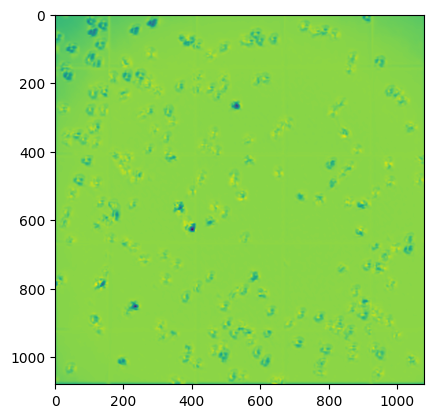

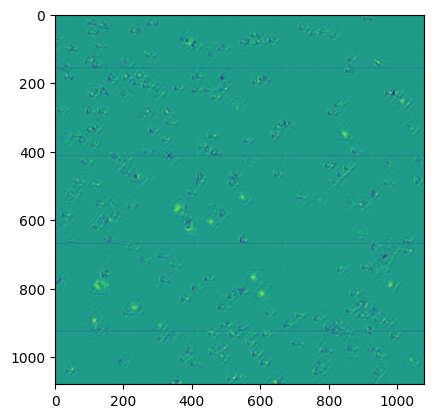

In [6]:
plt.imshow(get_encFeats_flat_cp)
plt.show()

plt.imshow(get_encFeats_flat_mask)
plt.show()

In [7]:
images_path_1059 = os.getcwd() + '/images_1059_0/'
images_1059 = import_images(images_path_1059,normalisation=True,num_imgs=5,format='.tiff')

In [9]:
instance_masks, masks, cps = model.eval(images_1059) #Making predictions

25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)


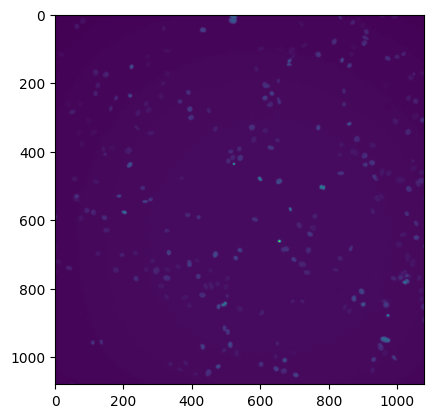

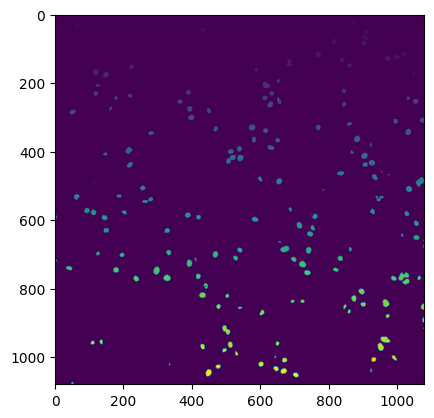

In [10]:
plt.imshow(images_1059[0])
plt.show()
plt.imshow(instance_masks[0])
plt.show()

In [51]:
#Get the first cell mask of the first instance mask

#Use that first instance mask to get the first encfeatures out (of the flat cp first)
encFeats_cp, encFeats_mask, pad_val = get_encFeats(model,images_1059[0])
encFeats_flat_cp = get_encFeats_flat(encFeats_cp,pad_val)
print(encFeats_flat_cp.shape)


#Then we can get on the second image and get all of the encfeatures of each instances of cells
#We can then do a comparison

#Importantly, we keep all this in functions to make it easily changeable

25
(1, 1, 256, 256)
(1080, 1080)


In [64]:
def get_instance_encFeats(instance_mask,encFeats):
    instance_encFeats = []
    for i in range(1,max(instance_mask.flatten())+1):
        instance_encFeats.append(np.delete(encFeats,np.where(instance_mask.flatten()!=i)))
    return np.array(instance_encFeats)

In [1]:
encFeats_cp, encFeats_mask, pad_val = get_encFeats(model,images_1059[0])
encFeats_flat_cp = get_encFeats_flat(encFeats_cp,pad_val)
instance_encFeats_0 = get_instance_encFeats(instance_masks[0],encFeats_flat_cp)

encFeats_cp, encFeats_mask, pad_val = get_encFeats(model,images_1059[1])
encFeats_flat_cp = get_encFeats_flat(encFeats_cp,pad_val)
instance_encFeats_1 = get_instance_encFeats(instance_masks[1],encFeats_flat_cp)

NameError: name 'get_encFeats' is not defined

In [77]:
print(instance_encFeats_0.shape)
print(instance_encFeats_1.shape)

array_first = instance_encFeats_0[0]

cos_sim = instance_encFeats_1[np.argmax(np.dot(array_first, instance_encFeats_1.T)/(np.linalg.norm(instance_encFeats_1)*np.linalg.norm(array_first)))]

(199,)
(197,)


ValueError: shapes (517,) and (197,) not aligned: 517 (dim 0) != 197 (dim 0)

In [79]:
print(array_first.shape)
print(max([i.shape for i in instance_encFeats_1]))

(517,)
(857,)


In [110]:
array = np.array([1,1,1,11])
new_arr = np.array([1,1,1,11,11,11])
pad_by = new_arr.shape[0]-array.shape[0]
print(np.pad(array, (0,pad_by), 'constant'))

[ 1  1  1 11  0  0]


In [109]:
array = np.array([1,1,1,11])
arr = np.resize(array,6,refcheck=False)
print(arr)

TypeError: _resize_dispatcher() got an unexpected keyword argument 'refcheck'

In [177]:
def resize_arrays_to_fit_another(arrays_to_resize,array):
    arrays_shaped = []
    for i in arrays_to_resize:
        if i.shape < array.shape:
            pad_by = array.shape[0]-i.shape[0]
            new_arr = np.pad(i, (0, pad_by), 'constant')
            arrays_shaped.append(new_arr)
        elif i.shape > array.shape:
            arrays_shaped.append(i[:array.shape[0]])
        else:
            arrays_shaped.append(i)
    arrays_shaped = np.array(arrays_shaped)
    return arrays_shaped

In [178]:
print(instance_encFeats_1.shape)
instance_encFeats_1_shaped = resize_arrays_to_fit_another(instance_encFeats_1,array_first)
print(instance_encFeats_1_shaped.shape)

print(np.unique([i.shape for i in instance_encFeats_1_shaped]))

(197,)
(197, 517)
[517]


In [124]:
print(instance_encFeats_0.shape)
print(instance_encFeats_1_shaped.shape)

array_first = instance_encFeats_0[0]

cos_sim_index = np.argmax(np.dot(array_first, instance_encFeats_1_shaped.T)/(np.linalg.norm(instance_encFeats_1_shaped)*np.linalg.norm(array_first)))
print(array_first)
print(cos_sim_index)

(199,)
(197, 517)
[-0.5854237  -0.637978   -0.70154035 -0.792022   -0.4411069  -0.52933455
 -0.5849665  -0.6243962  -0.6743006  -0.75404704 -0.83317405 -0.8971191
 -0.9371552  -0.9467891  -0.9316018  -0.8874104  -0.80789804 -0.36355963
 -0.45218217 -0.54524297 -0.60270876 -0.63968843 -0.68081945 -0.7445921
 -0.8060666  -0.8513     -0.87108696 -0.859731   -0.82949984 -0.7757669
 -0.69044286 -0.5726982  -0.36629143 -0.46164876 -0.5609179  -0.62702024
 -0.6691164  -0.7045692  -0.74659574 -0.77859175 -0.790542   -0.77556735
 -0.7316049  -0.6793802  -0.6135271  -0.5237194  -0.4075817  -0.30414888
 -0.276697   -0.36799613 -0.46810764 -0.57412916 -0.6520393  -0.7032559
 -0.7359471  -0.7563797  -0.75684816 -0.732196   -0.6786704  -0.5985193
 -0.52099216 -0.44067308 -0.345813   -0.23328058 -0.1438721  -0.0765991
 -0.27023938 -0.36507347 -0.47024035 -0.5841726  -0.67452073 -0.7361392
 -0.76960385 -0.7754401  -0.75293094 -0.70006436 -0.6147674  -0.5019235
 -0.39791274 -0.29922563 -0.19503187 -0.0

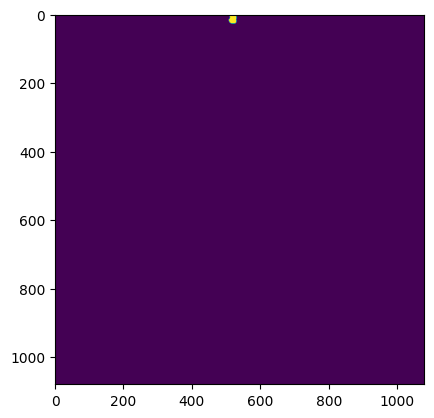

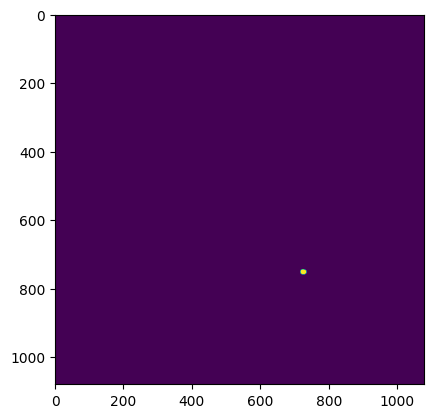

In [180]:
plt.imshow(np.where(instance_masks[0]==1,1,0))
plt.show()

plt.imshow(np.where(instance_masks[1]==cos_sim_index,1,0))
plt.show()

In [50]:
#found = np.ma.masked_where(instance_masks[0]!=1,encFeats_flat_cp)
found = np.delete(encFeats_flat_cp,np.where(instance_masks[0].flatten()!=1))

#found_clean = np.delete(found,np.where(found==0))
#found_clean = found_clean.flatten()
#found_clean = [x for x in found if x.isdigit()]

#print(np.unique(found_clean))
#print(found_clean)

(517,)


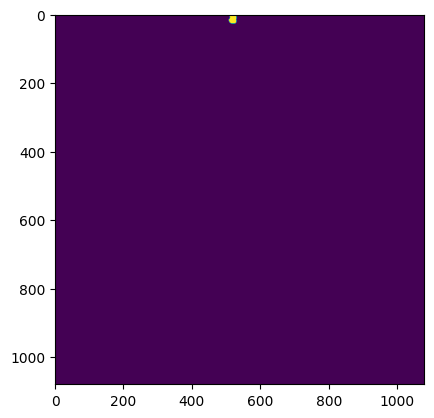

In [135]:
#get a radius of cells
#lets first get the centers of each cells
first_cell = np.where(instance_masks[0] == 1,1,0)
plt.imshow(first_cell); plt.show()

In [147]:
#I want to get the distance from one cell to all of the others
#That means a list of each cells index and their distance to that cell

centers_instance_mask = []
for i in range(1,max(instance_masks[0].flatten())+1):
    cell =  np.where(instance_masks[0] == i,1,0)
    M = cv2.moments(np.float32(cell))
    center = (int(M["m10"] / M["m00"]),int(M["m01"] / M["m00"]))
    centers_instance_mask.append(center)

[(518, 14), (831, 8), (869, 24), (63, 35), (431, 45), (322, 43), (908, 51), (905, 68), (814, 80), (902, 84), (767, 117), (1017, 116), (997, 124), (970, 129), (837, 134), (683, 142), (859, 149), (222, 153), (587, 161), (583, 158), (118, 169), (1076, 167), (1079, 169), (148, 176), (1075, 169), (1047, 174), (651, 194), (615, 207), (124, 207), (842, 224), (388, 228), (632, 231), (118, 231), (218, 237), (612, 244), (177, 244), (1030, 245), (653, 252), (1052, 254), (364, 255), (627, 263), (843, 263), (392, 276), (161, 275), (448, 281), (50, 285), (397, 301), (1072, 309), (993, 312), (858, 320), (574, 330), (768, 330), (468, 335), (614, 339), (1030, 343), (280, 347), (881, 364), (580, 366), (649, 368), (921, 381), (629, 389), (538, 393), (214, 397), (512, 401), (866, 403), (876, 401), (146, 408), (1075, 403), (1078, 404), (902, 413), (1075, 405), (512, 422), (540, 419), (924, 433), (217, 439), (905, 439), (952, 457), (1068, 457), (833, 464), (952, 460), (972, 460), (954, 463), (933, 475), (97

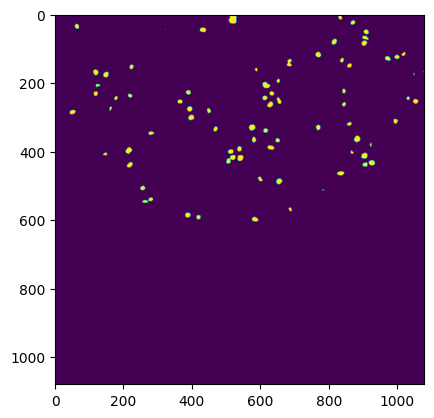

In [176]:
#get the distance of the first cell to the others

def get_center_distances(cell_centers,cell_num):
    center_distances = []
    a = np.array(centers_instance_mask[cell_num])
    for cell_center in cell_centers:
        b = np.array(cell_center)
        center_distances.append(np.linalg.norm(a-b))
    return center_distances

def get_cell_indexes_in_radius(center_distances,radius):
    center_distances = np.array(center_distances)
    indexes_of_cells_in_radius = np.squeeze(np.array(np.where(center_distances < radius)))
    indexes_of_cells_in_radius += 1
    return np.squeeze(np.array(indexes_of_cells_in_radius))

center_distances = get_center_distances(centers_instance_mask,0)
indexes_of_cells_in_radius = get_cell_indexes_in_radius(center_distances,radius=600)
plt.imshow(np.isin(instance_masks[0],indexes_of_cells_in_radius))
plt.show()

In [ ]:
#Now that we can get the indexes of cells in a radius, we want to use that to redo the comparison with the enc features but limited in a radius

In [145]:
max(instance_masks[0].flatten())

199

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


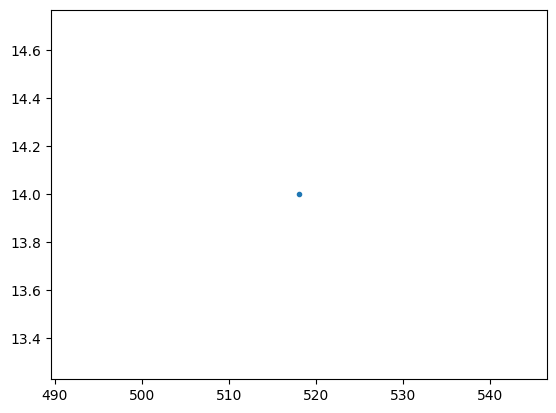

In [143]:
import cv2

M = cv2.moments(np.float32(first_cell))
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

plt.imshow(instance_masks[0])